In [1]:
include("../src/cliff7.jl")
using PyPlot
using Random
using LinearAlgebra

In [2]:
function haar_unitary(n, seed=nothing)
    eps = 1e-7
    while true
        if seed === nothing
            tmp = randn(n, n) + im .* randn(n, n)
        else
            rng = MersenneTwister(seed)
            tmp = randn(rng, n, n) + im .* randn(rng, n, n)
        end
        q, r = qr!(tmp)
        q = Array(q)
        ill_cond = false
        for i in 1:n
            tmp = abs(r[i ,i])
            if tmp < eps
                ill_cond = true
                break
            end
            q[:, i] *= r[i ,i] / tmp
        end
        ill_cond && continue
        return q
    end
end



"""
E_{over C's sign choice}[|tr(C)|^{2t}]
"""

function binary_prev_x1_symplectic_mat(n)
    b_mat = rand(Bool, 2n, 2n)
    b_mat[1, :] .= false
    b_mat[1, 1]  = true
    @views for i in 2:2n
        while true
            rand!(b_mat[i, :])
            if iseven(i) && !binary_symplectic_inner(b_mat[i, :], b_mat[i-1, :])
                continue
            end
            for j in 1:(isodd(i) ? i-1 : i-2)
                if binary_symplectic_inner(b_mat[i, :], b_mat[j, :])
                    k = isodd(j) ? j+1 : j-1
                    for l in 1:2n
                        b_mat[i, l] = b_mat[i, l] ⊻ b_mat[k, l]
                    end
                end
            end
            if all(.!b_mat[i, :])
                continue
            end
            break
        end
    end

    return b_mat
end

function binary_pxx_symplectic_mat(n)
    @assert n >= 2
    b_mat = rand(Bool, 2n, 2n)
    b_mat[1, :] .= false
    b_mat[1, 1]  = true
    b_mat[3, :] .= false
    b_mat[3, 3]  = true

    @views while !binary_symplectic_inner(b_mat[2, :], b_mat[1, :]) || binary_symplectic_inner(b_mat[2, :], b_mat[3, :])
        rand!(b_mat[2, :])
    end

    @views for i in 4:2n
        while true
            rand!(b_mat[i, :])
            if iseven(i) && !binary_symplectic_inner(b_mat[i, :], b_mat[i-1, :])
                continue
            end
            for j in 1:(isodd(i) ? i-1 : i-2)
                if binary_symplectic_inner(b_mat[i, :], b_mat[j, :])
                    k = isodd(j) ? j+1 : j-1
                    for l in 1:2n
                        b_mat[i, l] = b_mat[i, l] ⊻ b_mat[k, l]
                    end
                end
            end
            if all(.!b_mat[i, :])
                continue
            end
            break
        end
    end
    return b_mat
end

function binary_cc_symplectic_mat(n)
    @assert n%2 == 0
    m = div(n, 2)
    b_mat = rand(Bool, 4m, 4m)
    b_mat[1, :] .= false
    b_mat[1, 1]  = true
    b_mat[3, :] .= false
    b_mat[3, 2m+1]  = true

    @views while !binary_symplectic_inner(b_mat[2, :], b_mat[1, :]) || binary_symplectic_inner(b_mat[2, :], b_mat[3, :])
        rand!(b_mat[2, :])
    end

    @views for i in 4:4m
        while true
            rand!(b_mat[i, :])
            if iseven(i) && !binary_symplectic_inner(b_mat[i, :], b_mat[i-1, :])
                continue
            end
            for j in 1:(isodd(i) ? i-1 : i-2)
                if binary_symplectic_inner(b_mat[i, :], b_mat[j, :])
                    k = isodd(j) ? j+1 : j-1
                    for l in 1:2n
                        b_mat[i, l] = b_mat[i, l] ⊻ b_mat[k, l]
                    end
                end
            end
            if all(.!b_mat[i, :])
                continue
            end
            break
        end
    end

    for i in 1:4m
        b_mat[3, i], b_mat[2m+1, i] = b_mat[2m+1, i], b_mat[3, i]
        b_mat[4, i], b_mat[2m+2, i] = b_mat[2m+2, i], b_mat[4, i]
    end
    
    if rand() < 0.5
        for i in 1:4m
            b_mat[1, i], b_mat[2m+1, i] = b_mat[2m+1, i], b_mat[1, i]
            b_mat[2, i], b_mat[2m+2, i] = b_mat[2m+2, i], b_mat[2, i]
        end
    end

    return b_mat
end 


function rand_cliff_trace_power_2t_avg_over_sign(n, t)
    mat = binary_random_symplectic_matrix(n)
    for i in 1:2n
        mat[i, i] ⊻= true
    end
    x = 2n-length(binary_uppertrianglize!(mat)[1])
    # x: number of mutual stabilizers
    # 2^(x/2-n): inner product if non-vanish
    # 2^(-x): chance for non-vanish
    # 2^(n): (inner product  -> trace) normalizer
    return 2^(x*(t-1))
end

function px_rand_cliff_trace_power_2t_avg_over_sign(n, t)
    mat = binary_prev_x1_symplectic_mat(n)
    for i in 1:2n
        mat[i, i] ⊻= true
    end
    x = 2n-length(binary_uppertrianglize!(mat)[1])
    # x: number of mutual stabilizers
    # 2^(x/2-n): inner product if non-vanish
    # 2^(-x+1): chance for non-vanish
    # 2^(n): (inner product -> trace) normalizer
    return 2^(x*(t-1)+1)
end

function pxx_rand_cliff_trace_power_2t_avg_over_sign(n, t)
    mat = binary_pxx_symplectic_mat(n)
    for i in 1:2n
        mat[i, i] ⊻= true
    end
    x = 2n-length(binary_uppertrianglize!(mat)[1])
    # x: number of mutual stabilizers
    # 2^(x/2-n): inner product if non-vanish
    # 2^(-x+2): chance for non-vanish
    # 2^(n): (inner product -> trace) normalizer
    return 2^(x*(t-1)+2)
end


phi2(n) = 2

function phi3(n)
    p = 2
    if n==1
        return 2p+1
    else
        return 2p+2
    end
end

function phi4(n)
    p = 2
    if n==1 
        return p^3 + p^2 + p + 1
    elseif n==2
        return 2p^3 + 2p^2 + 2p + 1
    else
        return 2(p^3+p^2+p+1)
    end
end

function haar_phi(n, t)
    n==0 && return 1.
    n==1 && return factorial(2t) / factorial(t) / factorial(t+1)
    2^n>=t && return factorial(t)
    @assert false
    return 1.
end


function px_haar_phi(n, t)
    tmp = [binomial(t, k)^2 * haar_phi(n-1, k) * haar_phi(n-1, t-k) for k in 0:t]
    return sum(tmp)
end

function pxx_haar_phi(n, t)
    tmp = abs(sum([tr(haar_unitary(Int(2^(n-2)))) for _ in 1:4]))^(2t)
    return tmp
end

# function u_cliffor_phi(n, t)
#     return 2 * haar_phi(n-1, t) + 4 *  haar_phi(n-1, t)

pxx_haar_phi (generic function with 1 method)

In [48]:
g(n, t) = mean([rand_cliff_trace_power_2t_avg_over_sign(n, t) for _ in 1:100000])

g (generic function with 1 method)

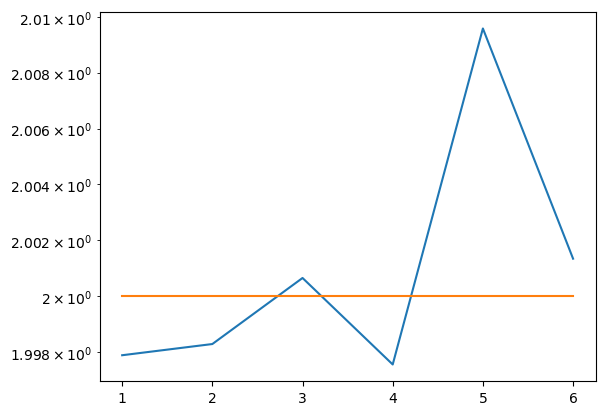

In [52]:
t = 2
n_list = 1:6

x = n_list
y1 = g.(n_list, t)
y2 = [phi2.(n) for n in x]

plot(x, y1, label="sim")
plot(x, y2, label="exact")

yscale("log")

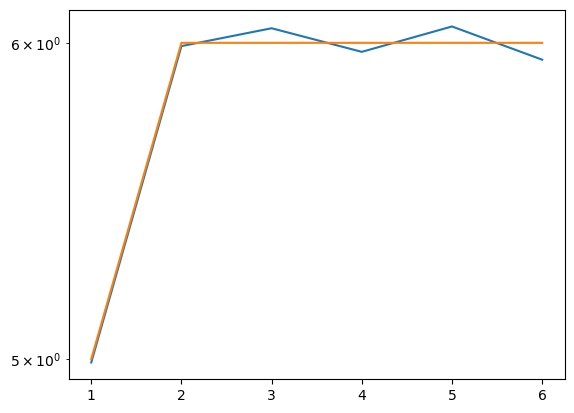

In [51]:
t = 3
n_list = 1:6

x = n_list
y1 = g.(n_list, t)
y2 = [phi3.(n) for n in x]

plot(x, y1, label="sim")
plot(x, y2, label="exact")

yscale("log")

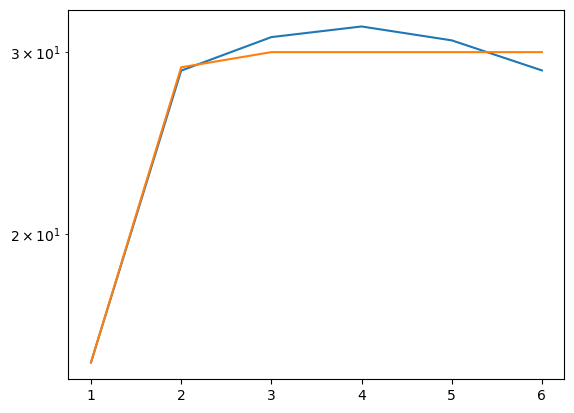

In [66]:
t = 4
n_list = 1:6

x = n_list
y1 = g.(n_list, t)
y2 = [phi4.(n) for n in x]

plot(x, y1, label="sim")
plot(x, y2, label="exact")

yscale("log")

In [21]:
function g2(n, t, avg)
    tmp = [px_rand_cliff_trace_power_2t_avg_over_sign(n, t) for _ in 1:avg]
    return mean(tmp), std(tmp) / sqrt(avg)
end

g2 (generic function with 1 method)

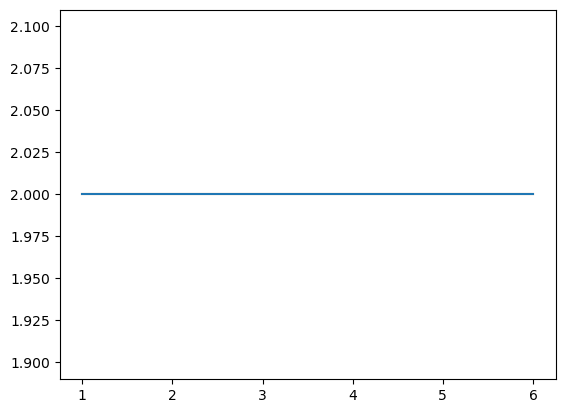

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000011BF6D0>

In [43]:
t = 1
n_list = 1:6
avg = 10000

tmp = [g2(n, t, avg) for n in n_list]

y = [a[1] for a in tmp]
ybar = [a[2] for a in tmp]

y_real = [px_haar_phi(n, t) for n in n_list]

errorbar(n_list, y, yerr=ybar, ms=2)

plot(n_list, y_real)

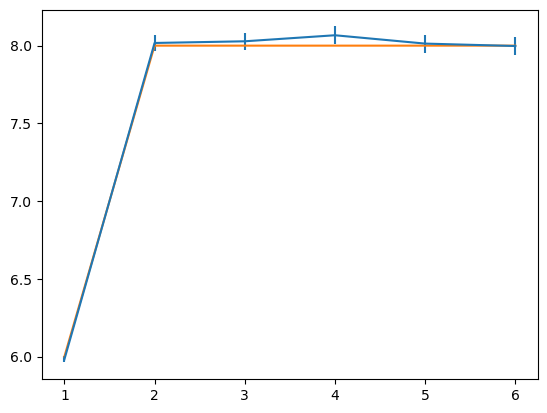

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000012E2D90>

In [44]:
t = 2
n_list = 1:6
avg = 10000

tmp = [g2(n, t, avg) for n in n_list]

y = [a[1] for a in tmp]
ybar = [a[2] for a in tmp]

y_real = [px_haar_phi(n, t) for n in n_list]

errorbar(n_list, y, yerr=ybar, ms=2)

plot(n_list, y_real)

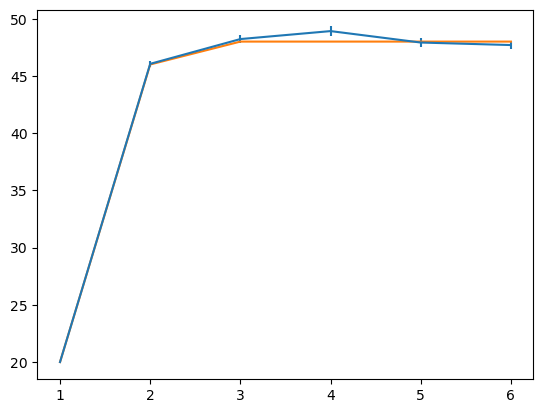

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001BC36D0>

In [45]:
t = 3
n_list = 1:6
avg = 100000

tmp = [g2(n, t, avg) for n in n_list]

y = [a[1] for a in tmp]
ybar = [a[2] for a in tmp]

y_real = [px_haar_phi(n, t) for n in n_list]

errorbar(n_list, y, yerr=ybar, ms=2)

plot(n_list, y_real)

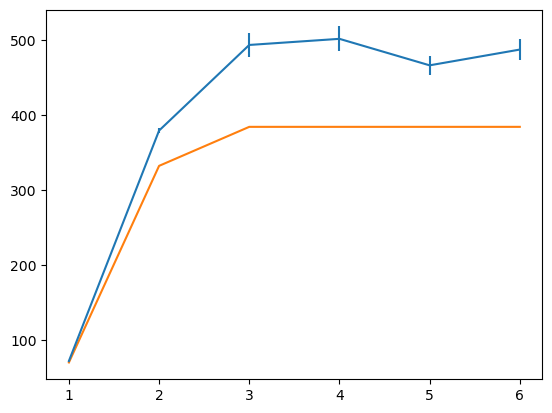

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001CF2CD0>

In [50]:
t = 4
n_list = 1:6
avg = 100000

tmp = [g2(n, t, avg) for n in n_list]

y = [a[1] for a in tmp]
ybar = [a[2] for a in tmp]

y_real = [px_haar_phi(n, t) for n in n_list]

errorbar(n_list, y, yerr=ybar, ms=2)

plot(n_list, y_real)

In [47]:
n = 1
avg = 10000
a = length(unique([binary_prev_x1_symplectic_mat(n) for _ in 1:avg]))
b = length(unique([binary_random_symplectic_matrix(n-1) for _ in 1:avg]))

@show a,b, a/b

(a, b, a / b) = (2, 1, 2.0)


(2, 1, 2.0)

In [39]:
n = 2
avg = 1000000
a = length(unique([binary_prev_x1_symplectic_mat(n) for _ in 1:avg]))
b = length(unique([binary_random_symplectic_matrix(n-1) for _ in 1:avg]))

@show a,b, a/b

(a, b, a / b) = (48, 6, 8.0)


(48, 6, 8.0)

In [41]:
n = 3
avg = 1000000
a = length(unique([binary_prev_x1_symplectic_mat(n) for _ in 1:avg]))
b = length(unique([binary_random_symplectic_matrix(n-1) for _ in 1:avg]))

@show a,b, a/b

(a, b, a / b) = (23040, 720, 32.0)


(23040, 720, 32.0)

In [57]:
function g3(n, t, avg)
    tmp = [pxx_rand_cliff_trace_power_2t_avg_over_sign(n, t) for _ in 1:avg]
    return mean(tmp), std(tmp) / sqrt(avg)
end

function g4(n, t, avg)
    tmp = [pxx_haar_phi(n, t) for _ in 1:avg]
    return mean(tmp), std(tmp) / sqrt(avg)
end

g4 (generic function with 1 method)

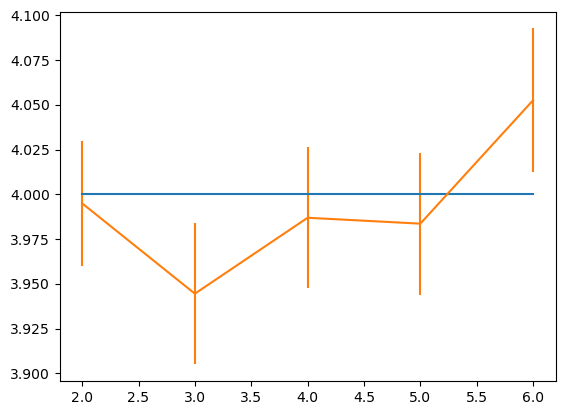

(PyObject <matplotlib.lines.Line2D object at 0x0000000001D526A0>, (), (PyObject <matplotlib.collections.LineCollection object at 0x0000000001D52A00>,))

In [63]:
t = 1
n_list = 2:6
avg = 10000

tmp1 = [g3(n, t, avg) for n in n_list]
tmp2 = [g4(n, t, avg) for n in n_list]

y = [a[1] for a in tmp1]
ybar = [a[2] for a in tmp1]

yy = [a[1] for a in tmp2]
yybar = [a[2] for a in tmp2]

errorbar(n_list, y, yerr=ybar, ms=2)
errorbar(n_list, yy, yerr=yybar, ms=2)


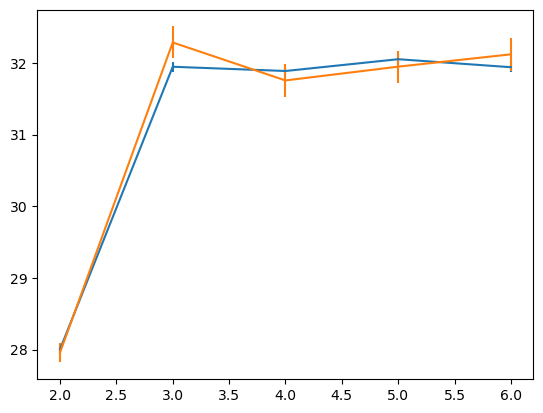

(PyObject <matplotlib.lines.Line2D object at 0x000000005B02DBB0>, (), (PyObject <matplotlib.collections.LineCollection object at 0x000000005B02DF10>,))

In [70]:
t = 2
n_list = 2:6
avg = 100000

tmp1 = [g3(n, t, avg) for n in n_list]
tmp2 = [g4(n, t, avg) for n in n_list]

y = [a[1] for a in tmp1]
ybar = [a[2] for a in tmp1]

yy = [a[1] for a in tmp2]
yybar = [a[2] for a in tmp2]

errorbar(n_list, y, yerr=ybar, ms=2)
errorbar(n_list, yy, yerr=yybar, ms=2)


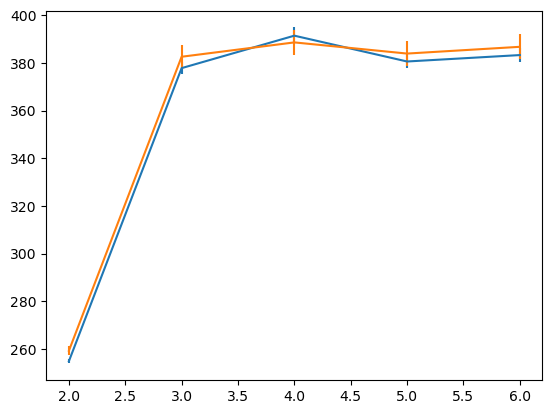

(PyObject <matplotlib.lines.Line2D object at 0x000000005B096A90>, (), (PyObject <matplotlib.collections.LineCollection object at 0x000000005B096DF0>,))

In [71]:
t = 3
n_list = 2:6
avg = 100000

tmp1 = [g3(n, t, avg) for n in n_list]
tmp2 = [g4(n, t, avg) for n in n_list]

y = [a[1] for a in tmp1]
ybar = [a[2] for a in tmp1]

yy = [a[1] for a in tmp2]
yybar = [a[2] for a in tmp2]

errorbar(n_list, y, yerr=ybar, ms=2)
errorbar(n_list, yy, yerr=yybar, ms=2)


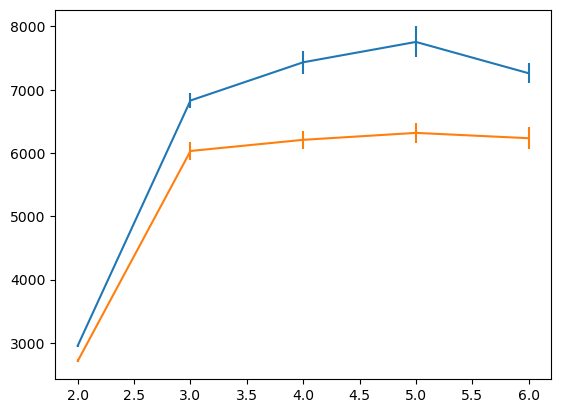

(PyObject <matplotlib.lines.Line2D object at 0x000000005AFCA790>, (), (PyObject <matplotlib.collections.LineCollection object at 0x000000005AFCAAF0>,))

In [69]:
t = 4
n_list = 2:6
avg = 100000

tmp1 = [g3(n, t, avg) for n in n_list]
tmp2 = [g4(n, t, avg) for n in n_list]

y = [a[1] for a in tmp1]
ybar = [a[2] for a in tmp1]

yy = [a[1] for a in tmp2]
yybar = [a[2] for a in tmp2]

errorbar(n_list, y, yerr=ybar, ms=2)
errorbar(n_list, yy, yerr=yybar, ms=2)


In [16]:
n = 10000
t = 2

tmp = mean([abs(tr(haar_unitary(2)))^(2t) for _ in 1:n])

2.0051515533467597

In [21]:
n = 100000
t = 2

tmp = mean([abs(tr(haar_unitary(2)) + tr(haar_unitary(1)) + tr(haar_unitary(1)))^(2t) for _ in 1:n])

15.975243361688614

In [40]:
tmp = [binary_cc_symplectic_mat(2) for _ in 1:10000]
tmp = unique(tmp)

16-element Array{Array{Bool,2},1}:
 [0 0 1 0; 1 0 1 1; 1 0 0 0; 0 1 1 0]
 [0 0 1 0; 1 0 0 1; 1 0 0 0; 1 1 1 0]
 [0 0 1 0; 1 0 0 1; 1 0 0 0; 0 1 1 0]
 [0 0 1 0; 0 0 0 1; 1 0 0 0; 1 1 0 0]
 [1 0 0 0; 1 1 1 0; 0 0 1 0; 1 0 0 1]
 [1 0 0 0; 1 1 0 0; 0 0 1 0; 0 0 1 1]
 [1 0 0 0; 1 1 0 0; 0 0 1 0; 0 0 0 1]
 [0 0 1 0; 0 0 0 1; 1 0 0 0; 0 1 0 0]
 [1 0 0 0; 0 1 1 0; 0 0 1 0; 1 0 1 1]
 [0 0 1 0; 0 0 1 1; 1 0 0 0; 0 1 0 0]
 [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1]
 [1 0 0 0; 0 1 1 0; 0 0 1 0; 1 0 0 1]
 [1 0 0 0; 1 1 1 0; 0 0 1 0; 1 0 1 1]
 [0 0 1 0; 0 0 1 1; 1 0 0 0; 1 1 0 0]
 [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 1 1]
 [0 0 1 0; 1 0 1 1; 1 0 0 0; 1 1 1 0]

In [93]:
function cliff_trace(cliff)
    xz, s = cliff.xz, cliff.s
    n = div(length(s), 2)
    mat = zeros(Bool, 2n, 4n)
    for i in 1:2n
        mat[i, i] = true
    end
    mat[1:2n, 2n+1:2n+2n] = xz

    xz_minus_i = copy(xz')
    for i in 1:2n
        xz_minus_i[i, i] ⊻= true
    end
    
    
#     display(mat)
    
    nullspace = binary_null_space(xz_minus_i)
#     display(nullspace)

    n_same = size(nullspace, 2)
    for i in 1:n_same
        tmp = 0, zeros(Bool, 4n)
        for j in 1:2n
            if nullspace[j, i]
                tmp = tmp * (s[j], mat[j, :])
            end
        end
#         @show tmp
        @assert tmp[1]==0 || tmp[1]==2
        @assert tmp[2][1:2n] == tmp[2][2n+1:4n]
        if tmp[1]==2
            return 0
        end
    end
    return 2^(n_same/2)
end

cliff_trace (generic function with 1 method)

In [91]:
# Random.seed!(6)
cl = random_clifford(2)
a = cliff_trace(cl)

4×1 Array{Bool,2}:
 1
 1
 0
 1

0

In [113]:
n = 2
avg = 10000
t = 2
mean([cliff_trace(random_clifford(n))^(2t) for _ in 1:avg])

1.9827

In [131]:
n = 2
avg = 100000
t = 2
mean([cliff_trace(random_cc_clifford(n))^(2t) for _ in 1:avg])

16.9424

In [11]:
tmp = [random_cc_clifford(2) for _ in 1:100000]
tmp = [(a.xz, a.s) for a in tmp]
tmp = unique(tmp)
tmp = [Clifford(a[1], a[2]) for a in tmp]

64-element Array{Clifford,1}:
 Clifford(Bool[1 0 0 0; 1 1 0 0; 0 0 1 0; 0 0 1 1], [0, 3, 0, 3])
 Clifford(Bool[0 0 1 0; 1 0 0 1; 1 0 0 0; 0 1 1 0], [0, 2, 0, 0])
 Clifford(Bool[1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1], [0, 2, 0, 0])
 Clifford(Bool[1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1], [0, 0, 0, 0])
 Clifford(Bool[1 0 0 0; 1 1 1 0; 0 0 1 0; 1 0 1 1], [0, 1, 0, 3])
 Clifford(Bool[0 0 1 0; 0 0 0 1; 1 0 0 0; 0 1 0 0], [0, 2, 0, 2])
 Clifford(Bool[1 0 0 0; 0 1 1 0; 0 0 1 0; 1 0 0 1], [0, 0, 0, 2])
 Clifford(Bool[0 0 1 0; 1 0 1 1; 1 0 0 0; 1 1 1 0], [0, 1, 0, 3])
 Clifford(Bool[0 0 1 0; 1 0 0 1; 1 0 0 0; 1 1 1 0], [0, 0, 0, 3])
 Clifford(Bool[1 0 0 0; 1 1 0 0; 0 0 1 0; 0 0 1 1], [0, 1, 0, 3])
 Clifford(Bool[0 0 1 0; 1 0 1 1; 1 0 0 0; 1 1 1 0], [0, 1, 0, 1])
 Clifford(Bool[0 0 1 0; 1 0 1 1; 1 0 0 0; 0 1 1 0], [0, 1, 0, 2])
 Clifford(Bool[0 0 1 0; 1 0 0 1; 1 0 0 0; 1 1 1 0], [0, 2, 0, 1])
 ⋮
 Clifford(Bool[0 0 1 0; 1 0 1 1; 1 0 0 0; 1 1 1 0], [0, 3, 0, 3])
 Clifford(Bool[0 0 1 0; 0 0 0 1; 1 0 0 0; 0

In [14]:
t=3
mean([abs_cliff_trace(a)^(2t) for a in tmp])

138.0

In [26]:
function rand_phase()
    a = rand() * 2pi
    return cos(a) + 1im * sin(a)
end

avg = 10000000
t = 3
a = mean([abs(1 + rand_phase() + rand_phase() + rand_phase())^(2t) for _ in 1:avg])
b = mean([abs(1 + rand_phase())^(2t) for _ in 1:avg])
c = (a+b)/2

137.9589560335456

In [32]:
swap = [1 0 0 0; 0 0 1 0; 0 1 0 0; 0 0 0 1]
CZ = [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 -1]
S = [1 0; 0 1im]
ii = [1 0; 0 1]
S1 = kron(S, ii)
S2 = kron(ii, S)

s = 0
for a in 0:1, b in 0:1, c in 0:3, d in 0:3
    s += abs(tr(swap^a * CZ^b * S1^c * S2^d))^4
end
s /= 64

17.0

In [3]:
all([true, true])

true

In [48]:
@views function preserve_X123_mat()
    bmat = zeros(Bool, 8, 8)
    for i in 1:6
        bmat[i, i] = true
    end
    for i in 1:3
        rand!(bmat[2i, 1:2:6])
        rand!(bmat[2i, 7:8])
        for j in 1:i-1
            if binary_symplectic_inner(bmat[2i, :], bmat[2j, :])
                bmat[2i, 2j-1] = xor(bmat[2i, 2j-1], true)
            end
        end
    end
    while all(bmat[7, :] .== false)
        rand!(bmat[7, 1:2:6])
        rand!(bmat[7, 7:8])
        for j in 1:3
            if binary_symplectic_inner(bmat[7, :], bmat[2j, :])
                bmat[7, 2j-1] = xor(bmat[7, 2j-1], true)
            end
        end
    end
    while all(bmat[8, :] .== false)
        while !binary_symplectic_inner(bmat[8, :], bmat[7, :])
            rand!(bmat[8, 1:2:6])
            rand!(bmat[8, 7:8])
        end
        for j in 1:3
            if binary_symplectic_inner(bmat[8, :], bmat[2j, :])
                bmat[8, 2j-1] = xor(bmat[8, 2j-1], true)
            end
        end
    end
    return bmat
end

function get_P4()
    bmat = zeros(Bool, 8, 8)
    for i in 1:4
        bmat[2i-1, 2i] = bmat[2i, 2i-1] = true
    end
    return bmat
end
    
    
function z2gauge_rand_cliff_trace_power_2t_avg_over_sign(t)
    mat = preserve_X123_mat()
    for i in 1:8
        mat[i, i] ⊻= true
    end
    x = 8-length(binary_uppertrianglize!(mat)[1])
    # x: number of mutual stabilizers
    # 2^(x/2-n): inner product if non-vanish
    # 2^(-x+2): chance for non-vanish
    # 2^(n): (inner product -> trace) normalizer
    return 2^(x*(t-1)+3)
end

z2gauge_rand_cliff_trace_power_2t_avg_over_sign (generic function with 1 method)

In [50]:
nn = 10000000
t = 2
mean([z2gauge_rand_cliff_trace_power_2t_avg_over_sign(t) for _ in 1:nn])

128.0187328

In [54]:
T = Bool[
        1 0 1 0 0 0 0 0;
        0 1 0 0 0 0 0 0;
        0 0 1 0 1 0 0 0;
        0 1 0 1 0 0 0 0;
        0 0 0 0 1 0 1 0;
        0 1 0 1 0 1 0 0;
        0 0 0 0 0 0 1 0;
        0 1 0 1 0 1 0 1]
P = get_P4()

isodd.(T*P*T')

8×8 BitArray{2}:
 0  1  0  0  0  0  0  0
 1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0
 0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0
 0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1
 0  0  0  0  0  0  1  0